In [1]:
import numpy as np
import matplotlib.pyplot as plt

# **Practical One**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('/home/tasneem/Desktop/MLatScale/ml-32m/ml-32m/ratings.csv')

In [4]:
data

,userId,movieId,rating,timestamp
0,1,17,4.0,944249077
1,1,25,1.0,944250228
2,1,29,2.0,943230976
3,1,30,5.0,944249077
4,1,32,5.0,943228858
...,...,...,...,...
32000199,200948,79702,4.5,1294412589
32000200,200948,79796,1.0,1287216292
32000201,200948,80350,0.5,1294412671
32000202,200948,80463,3.5,1350423800


In [5]:
userId_to_idx = {}
idx_to_userId = []

In [6]:
movieId_to_idx = {}
index_to_movieId = []
SparseMatrixBycolumn = []

In [7]:
userIdx = 0
movieIdx = 0

In [8]:
import csv
file_path = '/home/tasneem/Desktop/MLatScale/ml-32m/ml-32m/ratings.csv'
with open(file_path, 'r', newline='') as file:

    reader = csv.reader(file, delimiter=',')
    next(reader) # Skip the header row

    for row in reader:
      userId, movieId, rating, _ = int(row[0]), int(row[1]), float(row[2]), int(row[3])
      if not userId in userId_to_idx.keys() :
        userId_to_idx[userId] = userIdx
        idx_to_userId.append(userId)
        userIdx+=1

      if not movieId in  movieId_to_idx.keys():
        movieId_to_idx[movieId] = movieIdx
        index_to_movieId.append(movieId)
        movieIdx+=1

In [9]:
SparseMatrixByRow = [[] for _ in range(len(userId_to_idx))]
SparseMatrixByColumn = [[] for _ in range(len(movieId_to_idx))]

In [10]:
data_by_user_train = [[] for _ in range(len(userId_to_idx))]
data_by_user_test = [[] for _ in range(len(userId_to_idx))]

data_by_movie_train = [[] for _ in range(len(movieId_to_idx))]
data_by_movie_test = [[] for _ in range(len(movieId_to_idx))]

In [11]:
with open(file_path, 'r', newline='') as file:
  reader = csv.reader(file, delimiter = ',')
  next(reader)
  for row in reader:
    userId, movieId, rating, _ = int(row[0]), int(row[1]), float(row[2]), int(row[3])

    userIdIdx = userId_to_idx[userId]
    movieIdIdx = movieId_to_idx[movieId]

    SparseMatrixByRow[userIdIdx].append((movieIdIdx, rating))
    SparseMatrixByColumn[movieIdIdx].append((userIdIdx, rating))


    if np.random.random() <= 0.9:
      data_by_user_train[userIdIdx].append((movieIdIdx, rating))
      data_by_movie_train[movieIdIdx].append((userIdIdx, rating))
      #R[userIdIdx][movieIdIdx] = rating
    else:
      data_by_user_test[userIdIdx].append((movieIdIdx, rating))
      data_by_movie_test[movieIdIdx].append((userIdIdx, rating))





In [12]:
len(SparseMatrixByColumn[56])

38846

In [13]:
data_by_user_train[100][2][1]

4.0

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
def get_rated_movies_ids_for_user(userId):
  userIdx = userId_to_idx[userId]
  return SparseMatrixByRow[userIdx]


def get_users_by_movie_id(movieId):
  movieIdx = movieId_to_idx[movieId]
  return SparseMatrixByColumn[movieIdx]

In [16]:
degrees_of_users = {}

In [17]:
for userId in userId_to_idx.keys():
  user_movies = get_rated_movies_ids_for_user(userId)
  degree = len(user_movies)

  if degree in degrees_of_users.keys():
    degrees_of_users[degree] += 1
  else:
    degrees_of_users[degree] = 1

In [18]:
degrees_of_movies = {}

In [19]:
for movieId in movieId_to_idx.keys():
  movie_users = get_users_by_movie_id(movieId)
  degree = len(movie_users)

  if degree in degrees_of_movies.keys():
    degrees_of_movies[degree] += 1
  else:
    degrees_of_movies[degree] = 1

In [20]:
# Create scatter plot
users_degress = list(degrees_of_users.keys())
users_degress_frequencies = list(degrees_of_users.values())

movies_degrees = list(degrees_of_movies.keys())
movies_degress_frequencies = list(degrees_of_movies.values())


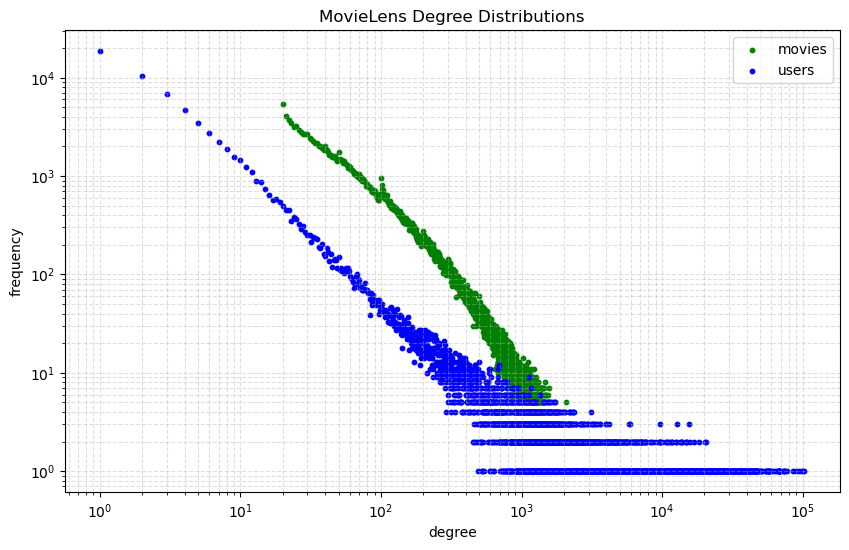

In [21]:
plt.figure(figsize=(10, 6))

plt.scatter(users_degress, users_degress_frequencies, s=10, color='green', label='movies')
plt.scatter(movies_degrees, movies_degress_frequencies, s=10, color='blue', label='users')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('degree')
plt.ylabel('frequency')
plt.legend()
plt.title('MovieLens Degree Distributions')
plt.grid(True, which="both", ls="--", alpha=0.4)
plt.show()

## *Are there power laws in the data? Is it scale-free?*


The data distribution appears to follow a power-law pattern. Both lines are nearly straight, indicating that the network is scale-free. This means it lacks a characteristic degree, and scaling the data by any constant factor would not alter the shape of the distribution—it would only rescale it.


# **Practical Two**

## **Initialization**

In [ ]:
num_users = len(data_by_user_train)
num_movies = len(data_by_movie_train)
lam = 0.5
gamma = 5
lr = 0.001
num_iters = 50

In [ ]:
biases_users = np.zeros(num_users)
biases_movies = np.zeros(num_movies)

In [ ]:
loss_function_train = []
loss_function_test = []
RMSE_train = []
RMSE_test = []

## **Defining loss functions**

In [ ]:
def compute_loss(data, user_biases, item_biases, mu, gamma):
    loss = 0.0
    # Flatten all ratings into arrays
    users = []
    items = []
    ratings = []
    for m in range(len(data)):
        for n, r in data[m]:
            users.append(m)
            items.append(n)
            ratings.append(r)

    users = np.array(users)
    items = np.array(items)
    ratings = np.array(ratings)

    # Predicted ratings
    preds = mu + user_biases[users] + item_biases[items]

    # Squared error
    loss = np.sum((ratings - preds) ** 2)

    # Regularization
    loss += gamma * (np.sum(user_biases ** 2) + np.sum(item_biases ** 2))
    return loss


In [ ]:
def compute_rmse(data, user_biases, item_biases, mu):
    # Flatten all ratings into arrays
    users = []
    items = []
    ratings = []
    for m in range(len(data)):
        for n, r in data[m]:
            users.append(m)
            items.append(n)
            ratings.append(r)

    users = np.array(users)
    items = np.array(items)
    ratings = np.array(ratings)

    # Predicted ratings
    preds = mu + user_biases[users] + item_biases[items]

    # RMSE
    rmse = np.sqrt(np.mean((ratings - preds) ** 2))
    return rmse

## **Training loop**

In [ ]:
mu = np.mean([r for user_ratings in data_by_user_train for _, r in user_ratings]) # Global Rating

In [ ]:
for iter in range(num_iters):
    # Update user biases
    for m in range(num_users):
        ratings = data_by_user_train[m]
        bias = 0
        item_counter = 0
        for n, r in ratings:
            b_movie = biases_movies[n]
            bias += lam * (r - b_movie)
            item_counter += 1
        if item_counter > 0:
            biases_users[m] = bias / (lam * item_counter + gamma)

    # Update movie biases
    for n in range(num_movies):
        ratings = data_by_movie_train[n]
        bias = 0
        user_counter = 0
        for m, r in ratings:
            b_user = biases_users[m]
            bias += lam * (r - b_user)
            user_counter += 1
        if user_counter > 0:
            biases_movies[n] = bias / (lam * user_counter + gamma)

    # Compute losses and RMSE 
    train_loss = compute_loss(data_by_user_train, biases_users, biases_movies, mu, gamma)
    test_loss = compute_loss(data_by_user_test, biases_users, biases_movies, mu, gamma)

    train_rmse = compute_rmse(data_by_user_train, biases_users, biases_movies, mu)
    test_rmse = compute_rmse(data_by_user_test, biases_users, biases_movies, mu)

    loss_function_train.append(train_loss)
    loss_function_test.append(test_loss)

    RMSE_train.append(train_rmse)
    RMSE_test.append(test_rmse)


## **Train and Test Losses over the number of iterations**

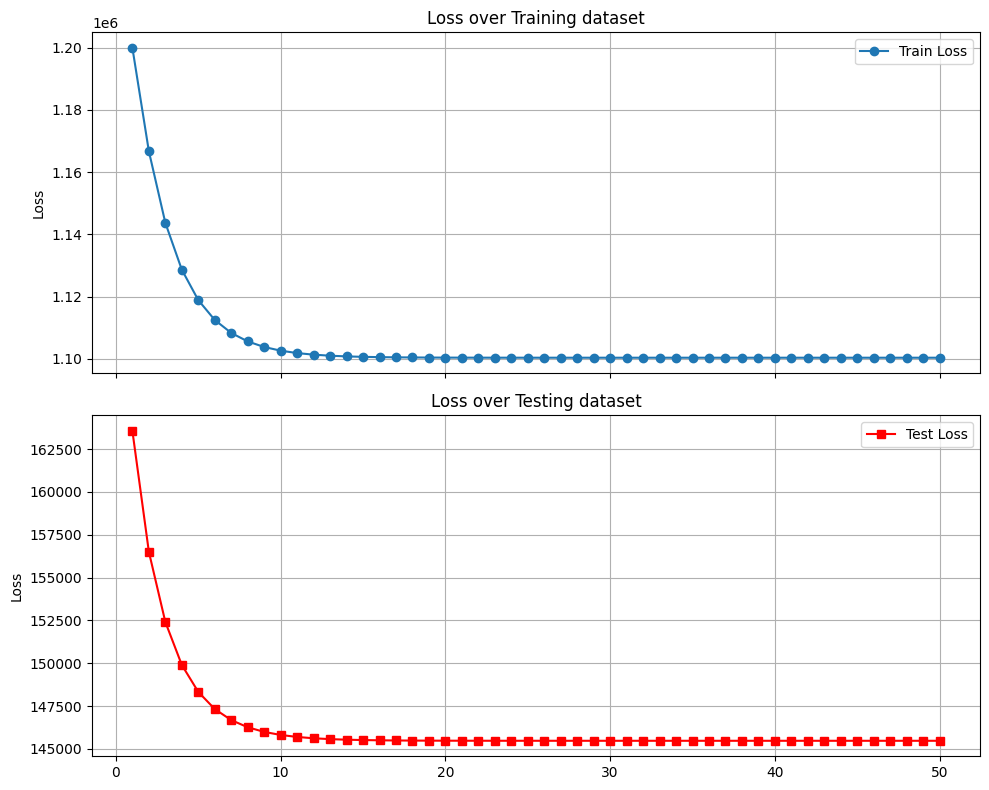

In [ ]:
iterations = range(1, len(loss_function_train) + 1)
iterations1 = range(1, len(loss_function_test) + 1)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot Loss
ax1.plot(iterations, loss_function_train, marker='o', label='Train Loss')
ax1.set_ylabel('Loss')
ax1.set_title('Loss over Training dataset')
ax1.legend()
ax1.grid(True)

ax2.plot(iterations1, loss_function_test, marker='s', color='red', label='Test Loss')
ax2.set_ylabel('Loss')
ax2.set_title('Loss over Testing dataset')
ax2.legend()
ax2.grid(True)
plt.tight_layout()
plt.show()

## **Train and Test Root Mean Square Errors over the number of iterations**

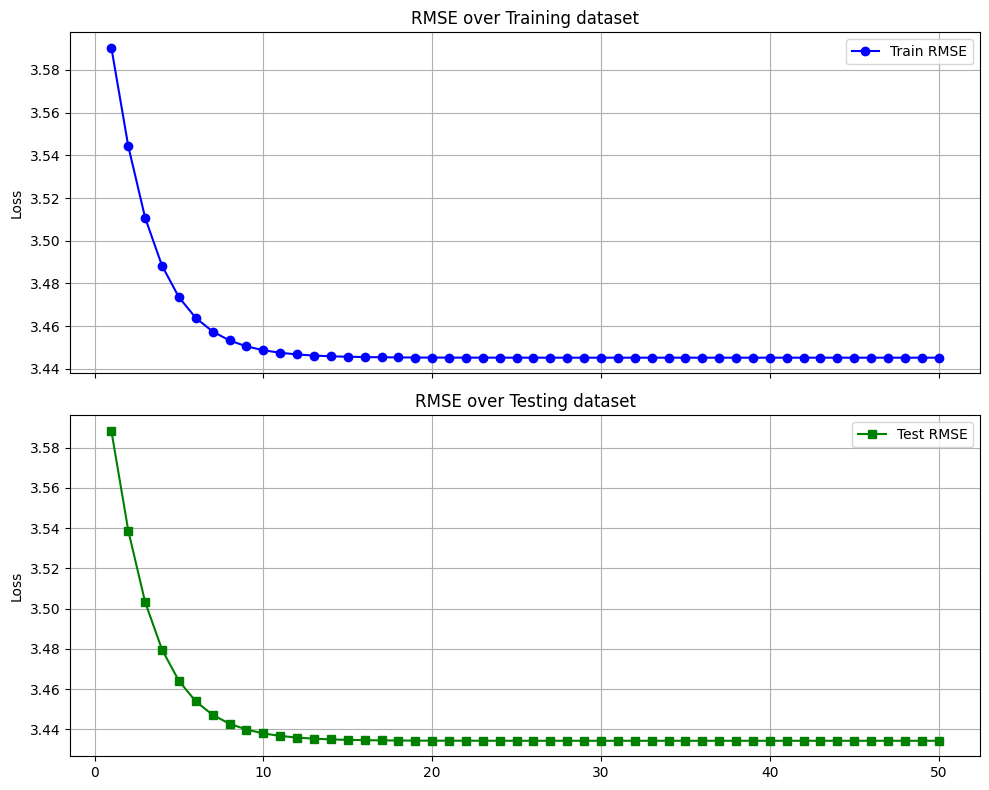

In [ ]:
iterations2 = range(1, len(RMSE_train) + 1)
iterations3 = range(1, len(RMSE_test) + 1)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot Loss
ax1.plot(iterations2, RMSE_train, marker='o', color='blue', label='Train RMSE')
ax1.set_ylabel('Loss')
ax1.set_title('RMSE over Training dataset')
ax1.legend()
ax1.grid(True)

ax2.plot(iterations3, RMSE_test, marker='s', color='green', label='Test RMSE')
ax2.set_ylabel('Loss')
ax2.set_title('RMSE over Testing dataset')
ax2.legend()
ax2.grid(True)
plt.tight_layout()
plt.show()

# **Practical Three**

## **Initialization**

In [22]:
num_users = len(data_by_user_train)
num_movies = len(data_by_movie_train)

K = 30 # Latent dimensions

U = np.random.normal(scale = 1, size= (num_users, K))
V = np.random.normal(scale = 1, size= (num_movies, K))

biases_users = np.zeros(num_users)
biases_movies = np.zeros(num_movies)

In [24]:
lam = 0.5
gamma = 0.5
tau = 10
num_iters = 15

In [25]:
loss_history_train = []
loss_history_test = []

RMSE_train_history = []
RMSE_test_history = []

## **Defining loss functions**

In [ ]:
def get_flattened_data(data_by_user):
    """
    Helper function to convert list-of-lists data into flat arrays for vectorization.

    Returns:
        u_indices (np.array): User indices
        i_indices (np.array): Item (movie) indices
        r_values (np.array): Rating values
    """
    u_list = []
    i_list = []
    r_list = []

    for u_idx, items in enumerate(data_by_user):
        for i_idx, rating in items:
            u_list.append(u_idx)
            i_list.append(i_idx)
            r_list.append(rating)

    return np.array(u_list, dtype=int), np.array(i_list, dtype=int), np.array(r_list)

def compute_loss_vectorized(data_by_user, user_biases, item_biases, U, V, lam, tau, gamma):
    """
    Vectorized computation of the ALS Loss function.
    """
    # 1. Flatten data for vectorized operations
    u_idxs, i_idxs, r_true = get_flattened_data(data_by_user)

    if len(r_true) == 0:
        # If no ratings, return only regularization costs
        reg_u = np.sum(U ** 2)
        reg_v = np.sum(V ** 2)
        reg_bu = np.sum(user_biases ** 2)
        reg_bi = np.sum(item_biases ** 2)
        return 0.5 * tau * (reg_u + reg_v) + 0.5 * gamma * (reg_bu + reg_bi)

    # 2. Calculate Predictions
    # Select relevant embeddings and biases using indices
    # U[u_idxs] shape: (N_ratings, k)
    # V[i_idxs] shape: (N_ratings, k)

    # Dot product interaction: element-wise multiply then sum along axis 1
    interaction = np.sum(U[u_idxs] * V[i_idxs], axis=1)

    # Full prediction: bu + bi + u.v
    preds = user_biases[u_idxs] + item_biases[i_idxs] + interaction

    # 3. Calculate Squared Errors
    errors = r_true - preds
    error_squared_sum = np.sum(errors ** 2)

    # 4. Calculate Regularization Terms
    # Sum of squared norms of all vectors
    reg_user = np.sum(U ** 2)
    reg_item = np.sum(V ** 2)
    reg_bias = np.sum(user_biases ** 2) + np.sum(item_biases ** 2)

    # 5. Total Loss
    loss = (0.5 * lam * error_squared_sum) + \
           (0.5 * tau * (reg_user + reg_item)) + \
           (0.5 * gamma * reg_bias)

    return loss

def compute_rmse_vectorized(data_by_user, user_biases, item_biases, U, V):
    """
    Vectorized computation of Root Mean Squared Error.
    """
    # 1. Flatten data
    u_idxs, i_idxs, r_true = get_flattened_data(data_by_user)

    if len(r_true) == 0:
        return 0.0

    # 2. Calculate Predictions
    interaction = np.sum(U[u_idxs] * V[i_idxs], axis=1)
    preds = user_biases[u_idxs] + item_biases[i_idxs] + interaction

    # 3. Calculate RMSE
    errors = r_true - preds
    mse = np.mean(errors ** 2)
    rmse = np.sqrt(mse)

    return rmse

## **Training Loop**

In [27]:
import random
from itertools import product

In [ ]:
def train_ALS_vectorized(data_by_user_train, data_by_user_test, data_by_movie_train, data_by_movie_test, num_users, num_movies, k, lam, tau, gamma, num_iters):
    """
    Vectorized Alternating Least Squares (ALS) training loop.

    Args:
        data_by_user: List of lists, where data_by_user[u] contains tuples (movie_idx, rating)
        data_by_movie: List of lists, where data_by_movie[i] contains tuples (user_idx, rating)
        num_users: Total number of users
        num_movies: Total number of movies
        k: Latent dimension size
        lam: Regularization parameter for error term (lambda)
        tau: Regularization parameter for magnitude of embedding vectors
        gamma: Regularization parameter for bias terms
        num_iters: Number of iterations (epochs)

    Returns:
        U, V, biases_users, biases_movies
    """

    # 1. Initialization
    # Initialize embeddings with small random values
    U = np.random.normal(scale=1.0/k, size=(num_users, k))
    V = np.random.normal(scale=1.0/k, size=(num_movies, k))

    # Initialize biases to zeros
    biases_users = np.zeros(num_users)
    biases_movies = np.zeros(num_movies)

    # 2. Pre-processing (Critical for vectorization)
    # Convert list-of-lists-of-tuples into a list of NumPy arrays for fast indexing.
    # This overhead is negligible compared to the training speedup.

    # Format: user_batches[u] = (array_of_item_indices, array_of_ratings)
    user_batches = []
    for u in range(num_users):
        if not data_by_user_train[u]:
            user_batches.append((np.array([], dtype=int), np.array([])))
        else:
            # Unzip the list of tuples into two tuples (indices, ratings) and convert to arrays
            idxs, rats = zip(*data_by_user_train[u])
            user_batches.append((np.array(idxs, dtype=int), np.array(rats)))

    # Format: movie_batches[i] = (array_of_user_indices, array_of_ratings)
    movie_batches = []
    for i in range(num_movies):
        if not data_by_movie_train[i]:
            movie_batches.append((np.array([], dtype=int), np.array([])))
        else:
            idxs, rats = zip(*data_by_movie_train[i])
            movie_batches.append((np.array(idxs, dtype=int), np.array(rats)))

    # 3. Main Loop
    print(f"Starting vectorized training for {num_iters} iterations...")

    # Create identity matrix once for regularization
    I_k = np.eye(k)

    for iter_count in range(num_iters):

        for u in range(num_users):
            item_indices, ratings = user_batches[u]
            n_items = len(item_indices)

            if n_items == 0:
                continue

            # 1. Fetch relevant movie embeddings and biases
            # V_subset shape: (n_items, k)
            V_subset = V[item_indices]
            bm_subset = biases_movies[item_indices]

            # 2. Update User Bias
            # Prediction without user bias: (U[u] @ V_subset.T) + bm_subset
            # dot product: (n_items, k) x (k,) -> (n_items,)
            interactions = V_subset @ U[u]

            # Calculate residuals: r - (u.v + bi)
            pred_no_user_bias = interactions + bm_subset
            residuals = ratings - pred_no_user_bias

            # Bias formula: sum(lambda * residuals) / (lambda * N + gamma)
            numerator_bias = np.sum(lam * residuals)
            denominator_bias = lam * n_items + gamma
            biases_users[u] = numerator_bias / denominator_bias

            # 3. Update User Embedding (U[u])
            # Least Squares formula: (lam * V.T @ V + tau * I)^-1 @ (lam * V.T @ (r - bi - bu))

            # Re-calculate error term with the NEW user bias
            # vector shape: (n_items,)
            error_vector = ratings - bm_subset - biases_users[u]

            # Construct Linear System Ax = b
            # LHS (Matrix A): lam * (V^T * V) + tau * I
            # shape: (k, n_items) @ (n_items, k) -> (k, k)
            lhs_matrix = lam * (V_subset.T @ V_subset) + tau * I_k

            # RHS (Vector b): lam * V^T * error
            # shape: (k, n_items) @ (n_items,) -> (k,)
            rhs_vector = lam * (V_subset.T @ error_vector)

            # Solve
            try:
                U[u] = np.linalg.solve(lhs_matrix, rhs_vector)
            except np.linalg.LinAlgError:
                # Fallback for singular matrices (rare with tau > 0)
                pass

        for i in range(num_movies):
            user_indices, ratings = movie_batches[i]
            n_users = len(user_indices)

            if n_users == 0:
                continue

            # 1. Fetch relevant user embeddings and biases
            U_subset = U[user_indices]
            bu_subset = biases_users[user_indices]

            # 2. Update Movie Bias
            # Prediction without movie bias
            interactions = U_subset @ V[i]

            pred_no_item_bias = interactions + bu_subset
            residuals = ratings - pred_no_item_bias

            numerator_bias = np.sum(lam * residuals)
            denominator_bias = lam * n_users + gamma
            biases_movies[i] = numerator_bias / denominator_bias

            # 3. Update Movie Embedding (V[i])
            # Re-calculate error term with NEW movie bias
            error_vector = ratings - bu_subset - biases_movies[i]

            # Construct Linear System
            lhs_matrix = lam * (U_subset.T @ U_subset) + tau * I_k
            rhs_vector = lam * (U_subset.T @ error_vector)

            try:
                V[i] = np.linalg.solve(lhs_matrix, rhs_vector)
            except np.linalg.LinAlgError:
                pass


        loss_train = compute_loss_vectorized(data_by_user_train, biases_users, biases_movies, U, V, lam, tau, gamma)
        loss_test = compute_loss_vectorized(data_by_user_test, biases_users, biases_movies, U, V, lam, tau, gamma)
        loss_history_train.append(loss_train)
        loss_history_test.append(loss_test)
        rmse_train = compute_rmse_vectorized(data_by_user_train, biases_users, biases_movies, U, V)
        rmse_test = compute_rmse_vectorized(data_by_user_test, biases_users, biases_movies, U, V)
        RMSE_train_history.append(rmse_train)
        RMSE_test_history.append(rmse_test)

        if (iter_count + 1) % 5 == 0:
            print(f"Iteration {iter_count + 1}/{num_iters} complete.")

    return U, V, biases_users, biases_movies

In [ ]:
U, V, biases_users, biases_movies = train_ALS_vectorized(data_by_user_train, data_by_user_test, data_by_movie_train, data_by_movie_test, num_users, num_movies, K, lam, tau, gamma, num_iters)

Starting vectorized training for 15 iterations...


In [27]:
param_grid = {
    'k': [10, 20, 30],
    'lam' : [0.1, 0.5, 1],
    'tau' : [5, 10, 15],
    'gamma' : [0.2, 0.5, 0.7]
}

In [28]:
def als_cross_validate_vectorized(data_by_user, num_users, num_movies, K_folds, k_latent, lam, tau, gamma, num_iters):
    """
    Performs K-fold cross-validation using the vectorized ALS implementation.

    Note: We only need data_by_user as input to generate the splits. The function
    reconstructs the necessary movie-indexed structures internally for training.
    """

    # 1. Extract all ratings into triplets (user_idx, movie_idx, rating)
    # This flattens the structure to make splitting easier
    all_ratings_triplets = []
    for u_idx in range(num_users):
        if u_idx < len(data_by_user):
            for m_idx, rating in data_by_user[u_idx]:
                all_ratings_triplets.append((u_idx, m_idx, rating))

    # 2. Shuffle and split these triplets into K_folds
    random.shuffle(all_ratings_triplets)
    n_ratings = len(all_ratings_triplets)
    fold_size = n_ratings // K_folds

    # Create indices for slices
    rating_folds = [all_ratings_triplets[i * fold_size : (i + 1) * fold_size] for i in range(K_folds)]

    # Handle remaining items if not perfectly divisible
    if n_ratings % K_folds != 0:
        rating_folds[-1].extend(all_ratings_triplets[K_folds * fold_size:])

    fold_scores = []

    print(f"Starting {K_folds}-fold Cross-Validation...")

    for val_index in range(K_folds):
        print(f"  Processing Fold {val_index + 1}/{K_folds}...")

        # --- A. Construct Train/Validation Sets ---
        val_triplets = rating_folds[val_index]

        # Combine all other folds for training
        train_triplets = []
        for j in range(K_folds):
            if j != val_index:
                train_triplets.extend(rating_folds[j])

        # --- B. Reconstruct Sparse Structures for Vectorized ALS ---
        # The vectorized trainer expects list-of-lists format
        current_train_by_user = [[] for _ in range(num_users)]
        current_train_by_movie = [[] for _ in range(num_movies)]

        for u, m, r in train_triplets:
            current_train_by_user[u].append((m, r))
            current_train_by_movie[m].append((u, r))

        # Structure for validation RMSE calculation
        current_val_by_user = [[] for _ in range(num_users)]
        for u, m, r in val_triplets:
            current_val_by_user[u].append((m, r))

        # --- C. Train (Vectorized) ---
        # Note: We silence the iteration prints inside the CV loop to reduce clutter
        U_trained, V_trained, bu_trained, bm_trained = train_ALS_vectorized(
            current_train_by_user,
            data_by_user_test,
            current_train_by_movie,
            data_by_movie_test,
            num_users,
            num_movies,
            k=k_latent,
            lam=lam,
            tau=tau,
            gamma=gamma,
            num_iters=num_iters
        )

        # --- D. Evaluate (Vectorized) ---
        rmse = compute_rmse_vectorized(
            current_val_by_user,
            bu_trained,
            bm_trained,
            U_trained,
            V_trained
        )

        fold_scores.append(rmse)
        print(f"    Fold {val_index + 1} RMSE: {rmse:.4f}")

    mean_rmse = np.mean(fold_scores)
    print(f"  >> Mean RMSE: {mean_rmse:.4f}")
    return mean_rmse

def grid_search_ALS_vectorized(data_by_user, num_users, num_movies, param_grid, K_folds=3, num_iters=10):
    """
    Performs grid search using the vectorized cross-validation function.
    """
    keys = list(param_grid.keys())
    values = list(param_grid.values())

    best_score = float('inf')
    best_params = None
    all_results = []

    # Generate all combinations of parameters
    combinations = list(product(*values))
    total_combos = len(combinations)

    print(f"Starting Grid Search over {total_combos} combinations...")

    for idx, combo in enumerate(combinations):
        params = dict(zip(keys, combo))
        print(f"\n[{idx+1}/{total_combos}] Testing combination: {params}")

        # Call the vectorized CV function
        score = als_cross_validate_vectorized(
            data_by_user=data_by_user,
            num_users=num_users,
            num_movies=num_movies,
            K_folds=K_folds,
            k_latent=params['k'],
            lam=params['lam'],
            tau=params['tau'],
            gamma=params['gamma'],
            num_iters=num_iters
        )

        all_results.append((params, score))

        if score < best_score:
            best_score = score
            best_params = params
            print(f"  ** New Best Score: {best_score:.4f} **")

    print("\nGrid Search Complete.")
    print(f"Best RMSE: {best_score:.4f}")
    print(f"Best Params: {best_params}")

    return best_params, best_score, all_results

In [ ]:
best_params, best_score, all_results = grid_search_ALS_vectorized(data_by_user_train, num_users, num_movies, param_grid, K_folds=3, num_iters=10)

Starting Grid Search over 81 combinations...

[1/81] Testing combination: {'k': 10, 'lam': 0.1, 'tau': 5, 'gamma': 0.2}
Starting 3-fold Cross-Validation...
  Processing Fold 1/3...
Starting vectorized training for 10 iterations...


## **Train and Test Losses over the number of iterations**

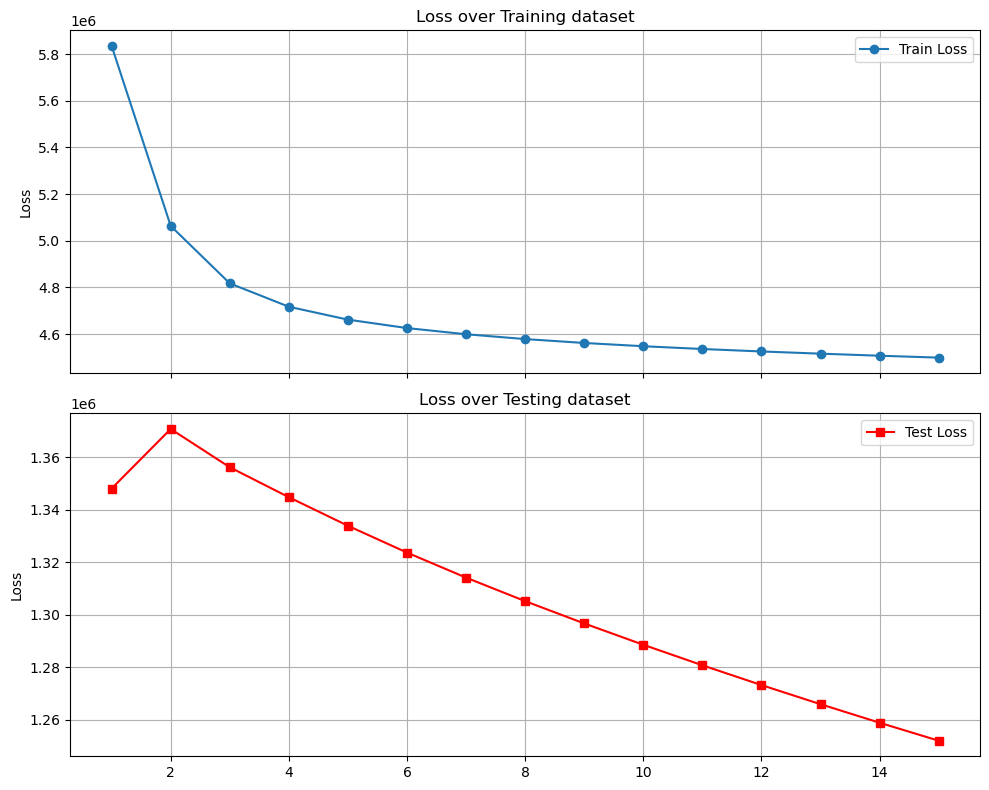

In [39]:
iterations = range(1, len(loss_history_train) + 1)
iterations1 = range(1, len(loss_history_test) + 1)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot Loss
ax1.plot(iterations, loss_history_train, marker='o', label='Train Loss')
ax1.set_ylabel('Loss')
ax1.set_title('Loss over Training dataset')
ax1.legend()
ax1.grid(True)

ax2.plot(iterations1, loss_history_test, marker='s', color='red', label='Test Loss')
ax2.set_ylabel('Loss')
ax2.set_title('Loss over Testing dataset')
ax2.legend()
ax2.grid(True)
plt.tight_layout()
plt.show()

## **Train and Test Root Mean Squared Errors over the number of iterations**

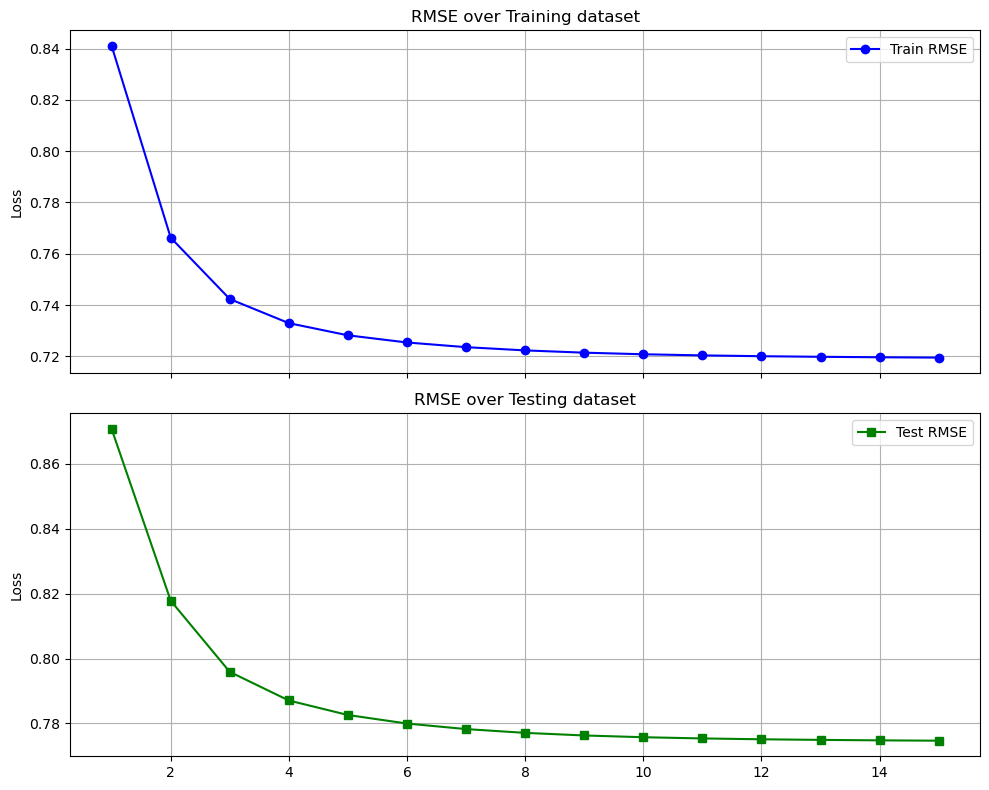

In [40]:
iterations2 = range(1, len(RMSE_train_history) + 1)
iterations3 = range(1, len(RMSE_test_history) + 1)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot Loss
ax1.plot(iterations2, RMSE_train_history, marker='o', color='blue', label='Train RMSE')
ax1.set_ylabel('Loss')
ax1.set_title('RMSE over Training dataset')
ax1.legend()
ax1.grid(True)

ax2.plot(iterations3, RMSE_test_history, marker='s', color='green', label='Test RMSE')
ax2.set_ylabel('Loss')
ax2.set_title('RMSE over Testing dataset')
ax2.legend()
ax2.grid(True)
plt.tight_layout()
plt.show()